# Finding Heavy Traffic Indicators on [I-94](https://en.wikipedia.org/wiki/Interstate_94)

In this analysis, we will attempt to determine the indicators of heavy traffic on I-94.

The dataset was collected by John Hogue and can be downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

In [2]:
import pandas as pd
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [3]:
print(traffic.head())
print('\n')
print(traffic.tail())
print('\n')
print(traffic.info())

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  


      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0 

Some of the possible influencing factors could be weather, time of the day, time of the week, etc... Let's take a look at the data dictionary.

|**Col header**|**Description**|
|---|---|
|`holiday`|States if it is a US National holiday|
|`temp`|Average temperature in Kelvins|
|`rain_1h`|Amount (in mm) of rain within the hour|
|`snow_1h`|Amount (in mm) of snow within the hour|
|`clouds_all`|Percentage of cloud cover|
|`weather_main`|Short textual description of current weather|
|`weather_description`|Long textual description of current weather|
|`date_time`| Hour of the data collected in CST time|
|`traffic_volume`|Hourly I-94 ATR 301 reported westbound traffic volume|

There are a total of 48204 entries with data collected from 2 Oct 2012 til 30 Sep 2018.

![](https://s3.amazonaws.com/dq-content/524/i94_figma.png)

According to the [dataset documentation](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume), the station recording the data is approximately midway between Minneapolis and Saint Paul. The station only records westbound traffic, so we should we avoid generelising results for the entire I-94 highway. Whatever we conclude may not be relevant to the eastbound traffic.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## Analysing traffic volume

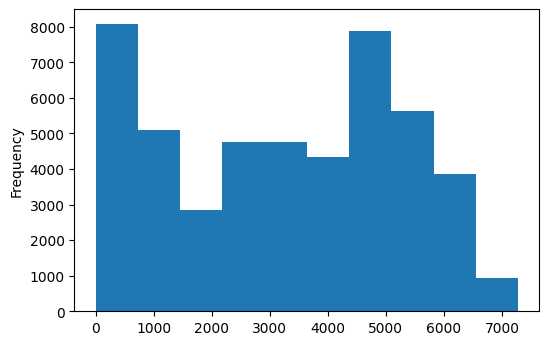

In [5]:
traffic['traffic_volume'].plot.hist()
plt.show()

In [6]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

The mean number of westbound vehicles passing the station per hour is about 3259. There are certain times of the day where 0 vehicles travel westwards (this is likely during the wee hours of the day). At its peak, 7280 vehicles travel westwards along the I-94.


# Impact of time on traffic volume
## Day vs Night

We shall explore further and split the dataset into two parts
- Daytime data: hours from 7a.m. to 7p.m. (12 hours)
- Nighttime data: hours from 7p.m. to 7a.m. (12 hours)

In [7]:
traffic['date_time']=pd.to_datetime(traffic['date_time'])

In [8]:
traffic['hour']=traffic['date_time'].dt.hour
daytime = traffic.copy()[(traffic['hour']<19) & (traffic['hour']>=7)]
nighttime=traffic.copy()[(traffic['hour']<7) | (traffic['hour']>=19)]

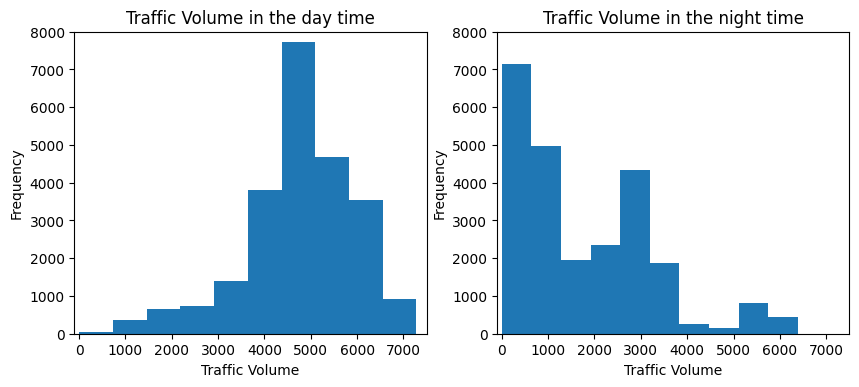

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(daytime['traffic_volume'])
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.title('Traffic Volume in the day time')
plt.xlim([-100,7500])
plt.ylim([0,8000])

plt.subplot(1,2,2)
plt.hist(nighttime['traffic_volume'])
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.title('Traffic Volume in the night time')
plt.xlim([-100,7500])
plt.ylim([0,8000])
plt.show()

In [10]:
print(daytime['traffic_volume'].describe(),'\n')
print(nighttime['traffic_volume'].describe())

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64 

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64


From the histogram, we can see the that traffic volume in the day time is left skewed, suggesting that the traffic volume is high most of the time. More than 4252 cars travel westbound 75% of the time.

Traffic volume in the night time is right skewed, suggesting that traffic is low most of the time. Less than 2819 cars travel westbound 75% of the time. 

Although there are some counts of high traffic volume in the night time, it is a minority. Since we are looking at indicators of high traffic volume, we will focus our study on traffic volume in the day time.

## Daytime traffic volume analysis

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:

- Month
- Day of the week
- Time of day

In [11]:
daytime['month']=daytime['date_time'].dt.month
by_month = daytime.groupby('month').mean()
print(by_month.head(),'\n')
by_month['traffic_volume']

             temp   rain_1h   snow_1h  clouds_all  traffic_volume       hour
month                                                                       
1      265.483409  0.015080  0.000631   58.554108     4495.613727  12.386774
2      266.663789  0.004019  0.000000   51.550459     4711.198394  12.351491
3      273.619940  0.015839  0.000000   56.827811     4889.409560  12.363933
4      279.661071  0.105343  0.000000   59.221525     4906.894305  12.492278
5      289.282668  0.130863  0.000000   56.548825     4911.121609  12.478300 



month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

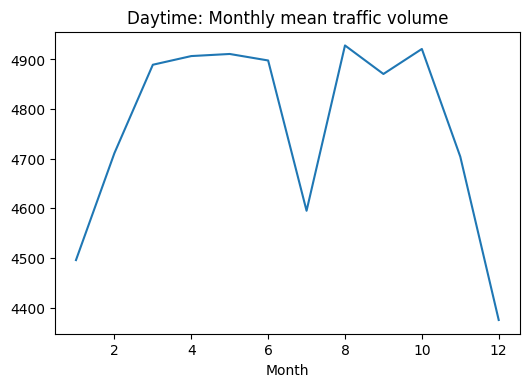

In [12]:
by_month['traffic_volume'].plot.line()
plt.title("Daytime: Monthly mean traffic volume")
plt.xlabel('Month')
plt.show()

The monthly mean traffic volume seems to suggest that the traffic volume is lower during winter months. But there is 1 anomaly: The dip in July. We may need to investigate a little deeper into this.

In [13]:
daytime['dayofweek']=daytime['date_time'].dt.dayofweek
by_dayofweek=daytime.groupby('dayofweek').mean()

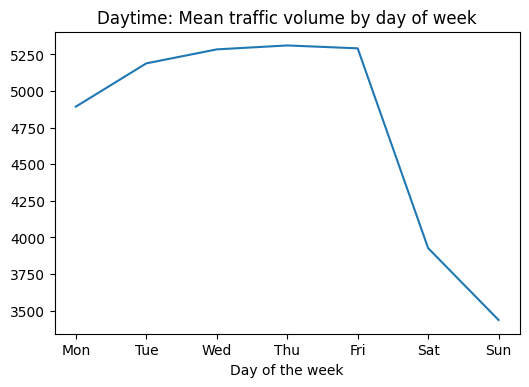

In [14]:
by_dayofweek['traffic_volume'].plot.line()
plt.title('Daytime: Mean traffic volume by day of week')
plt.xlabel('Day of the week')
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

The above line plot shows that traffic volume dips during the weekends suggesting that work is a major contributor to the traffic volume.

In [15]:
daytime['hour']=daytime['date_time'].dt.hour
business_days=daytime.copy()[daytime['dayofweek']<=4]
weekend=daytime.copy()[daytime['dayofweek']>4]
by_hour_business = business_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

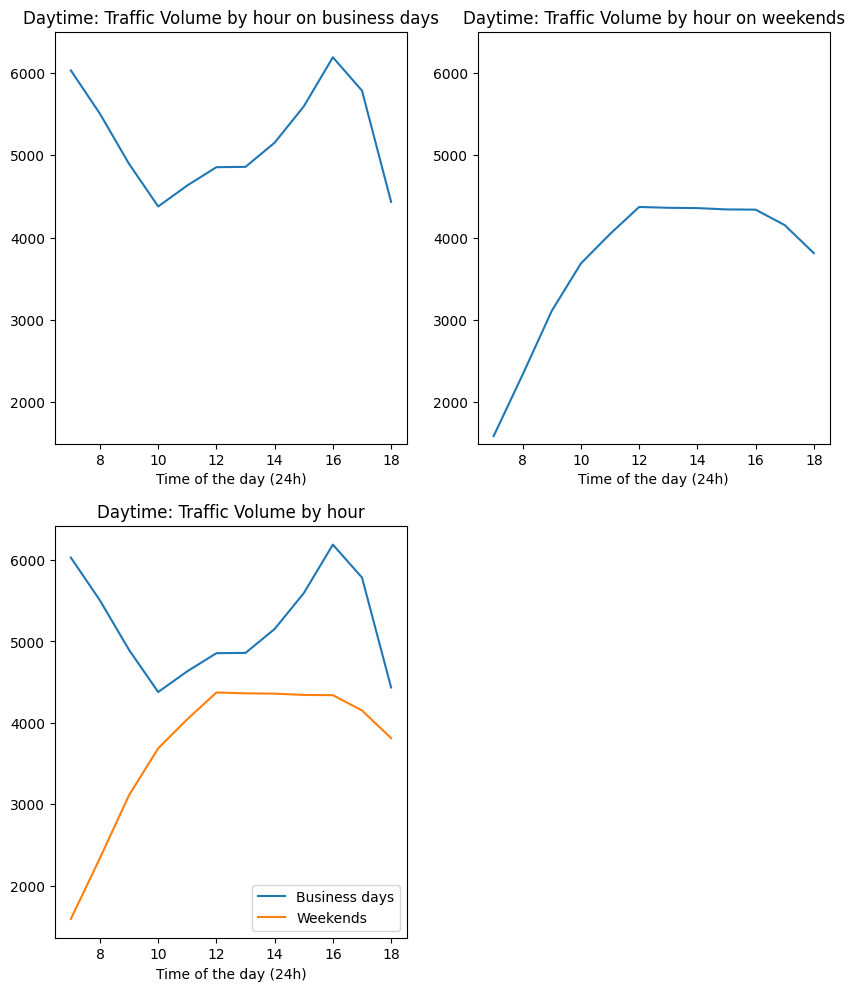

In [16]:
plt.figure(figsize=(10,12))
plt.subplot(2,2,1)
by_hour_business['traffic_volume'].plot.line()
plt.title('Daytime: Traffic Volume by hour on business days')
plt.ylim([1500,6500])
plt.xlabel('Time of the day (24h)')

plt.subplot(2,2,2)
by_hour_weekend['traffic_volume'].plot.line()
plt.title('Daytime: Traffic Volume by hour on weekends')
plt.ylim([1500,6500])
plt.xlabel('Time of the day (24h)')

plt.subplot(2,2,3)
plt.plot(by_hour_business['traffic_volume'], label='Business days')
plt.plot(by_hour_weekend['traffic_volume'],label = 'Weekends')
plt.xlabel('Time of the day (24h)')
plt.title('Daytime: Traffic Volume by hour')
plt.legend()

plt.show()

On business days, the traffic peaks at 7am and 4pm which coincides with working hours. This is expected and doesn't really generate any new insight. However, on the weekends, the traffic peaks between 12pm to 4pm. This could be due to commuters sleeping in and starting their day later.

## Summary of the impacting of timing on traffic
**Day vs Night**
There is a more frequent occurrence of high traffic in the day time compared to night time. So this raises the question "what time?"

**Time of the day**
On business days it peaks at 7am and 4pm.
On weekends it peaks between 12pm to 4pm.

**Business day vs weekend**
Unsurprisingly, traffic is generally higher on business days as compared to the weekends

**Seasonality of traffic**
Traffic is generally consistent throughout and dips during the winter months, but the dip isn't really significant. The mean number of cars drop by roughly 10% (4900 to 4500) during the winter months compared to the rest of the year.

# Impact of weather conditions traffic

Having taken a look at how timing affects traffic conditions, we shall now examine the impact of weather. We shall first explore the numerical indicators: temperature, rainfall, snowfall and cloud cover.

**Correlation between day traffic and the above weather metrics**

In [28]:
daytime.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
hour              0.172704
month            -0.022337
dayofweek        -0.416453
Name: traffic_volume, dtype: float64

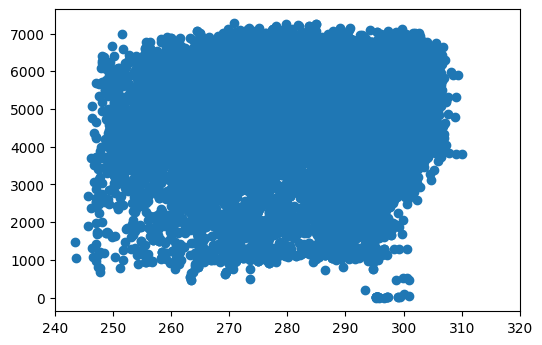

In [30]:
plt.scatter(daytime['temp'],daytime['traffic_volume'])
plt.xlim([240,320])
plt.show()

From the correlation data, temperature shows the greatest correlation to traffic volume, but upon inspecting the scatter plot, nothing noteworthy appears.

**Qualitative aspects of weather**

We shall now see what we can gather from the weather descriptions.

In [32]:
by_weather_main=daytime.groupby('weather_main').mean()

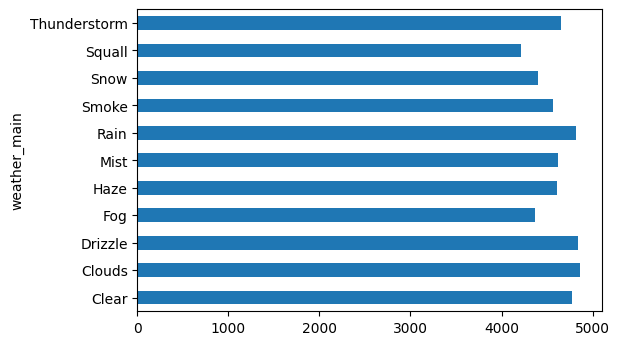

In [34]:
by_weather_main['traffic_volume'].plot.barh()
plt.show()

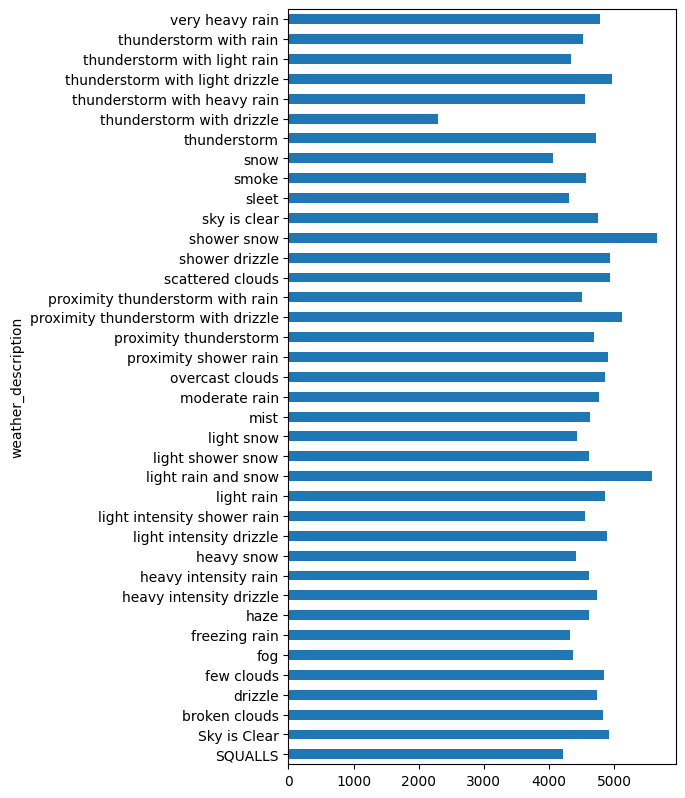

In [44]:
by_weather_description=daytime.groupby('weather_description').mean()
by_weather_description['traffic_volume'].plot.barh(figsize=(5,10))
plt.show()

From the above weather descriptions, it appears that heavier traffic occurs when there is
- shower snow
- light rain and snow
- proximity thunderstorm with drizzle

## Conclusion
The following factors contribute to higher traffic volume:
- Daytime
- 7am and 4pm on business days
- 12pm - 4pm on weekends
- 